# Ускорение и оптимальные методы (20 баллов)

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import math
import warnings
warnings.filterwarnings('ignore')

seed = 57
rng = np.random.default_rng(seed)

## Основная часть (10 баллов)

Рассмотрим задачу минимизации эмпирического риска (Emperical Risk Minimization):

$$
\min_{x \in \mathbb{R}^d} \left[ f(x) = \frac{1}{n} \sum_{i=1}^n \ell \left(g(x, a_i), b_i \right) + \frac{\lambda}{2} \| x \|^2_2 \right],
$$

где:
- $\ell(\cdot, \cdot) : \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ — функция потерь на одном элементе;
- $g(\cdot, \cdot) : \mathbb{R}^{d} \times \mathbb{R}^{d} \to \mathbb{R}$ — модель;
- $x \in \mathbb{R}^d$ — вектор параметров модели;
- $\{ a_i \}_{i = 1}^n \in \mathbb{R}^{d}$ — векторы-признаков $\left(\text{при транспонировании образуют в совокупности строки дата-матрицы}~ A \in \mathbb{R}^{n \times d}\right)$;
- $\{ b_i \}_{i = 1}^n \in \mathbb{R}$ — целевые значения $\left(\text{в совокупности образующие таргет-вектор }b \in \mathbb{R}^n\right)$;
- $\lambda > 0$ — параметр регуляризации.

В данной домашней работе предлагается рассмотреть в качестве
- модели $g(\cdot, \cdot)$ комбинацию _линейной_ и _логистической_ (или _сигмоидной_) функций:

$$
g(x, a_i) = \frac{1}{1 + \exp \left[- \langle x, a_i \rangle\right]};
$$

- функции потерь на одном элементе $\ell(\cdot, \cdot)$ _кросс-энтропию_:

$$
\ell(g(x, a_i), b_i) = -b_i \log \left[g(x, a_i)\right] - (1 - b_i) \log \left[1 -  g(x, a_i)\right].
$$

__Задача 1.__ Прежде чем мы перейдем к оптимизационным методам, вычислим все основные константы, а также произведем небольшой препроцессинг данных.


__а) (0.5 балла)__ Докажите, что градиент фунции $f(x)$ равен

$$
\nabla f(x) = \frac{1}{n} \sum_{i=1}^n (g(x, a_i) - b_i) a_i + \lambda x.
$$

In [ ]:
# Ваше решение (Markdown)

### Решение
Пусть $s_i=( x,a_i), p_i=\sigma(s_i)=g(x,a_i) \$ <br>
Для 1 слагаемого:<br>

$\nabla_x\,\ell(p_i,b_i)
=\frac{\partial \ell}{\partial p}(p_i,b_i)\cdot\frac{\partial p_i}{\partial s_i}\cdot\nabla_x s_i.$

$\frac{\partial \ell}{\partial p}(p,b)=-\frac{b}{p}+\frac{1-b}{1-p}$ <br>
$\frac{\partial p}{\partial s}=\sigma(s)(1-\sigma(s))=p(1-p)$ <br>
$\nabla_x s_i=\nabla_x \langle x,a_i\rangle=a_i$ <br>

Из предыдуших выражений:<br>
$(-\frac{b_i}{p_i}+\frac{1-b_i}{1-p_i})p_i(1-p_i)\,a_i
=\bigl(-b_i(1-p_i)+(1-b_i)p_i\bigr)a_i
=(p_i-b_i)\,a_i$

Следовательно,<br>
$\nabla_x[\frac{1}{n}\sum_{i=1}^{n}\ell\!(g(x,a_i),b_i)]
=\frac{1}{n}\sum_{i=1}^{n}(g(x,a_i)-b_i)\,a_i$

Учтя, что градиент L2-регуляризатора: $\nabla_x(\frac{\lambda}{2}\|x\|_2^2)=\lambda x$: <br>
Получаем требуемое:
$$
\nabla f(x) = \frac{1}{n} \sum_{i=1}^n (g(x, a_i) - b_i) a_i + \lambda x.
$$

__б) (1 балл)__ Докажите, что константа Липшица градиента $L$ может быть оценена как:

$$
L \geq \frac{1}{4n} \lambda_{\max} \left[A^\top A \right] + \lambda,
$$

где $A$ — дата-матрица, определенная в начале работы.

In [ ]:
# Ваше решение (Markdown)

### Решение

$f(x) = \frac{1}{n}\sum_{i=1}^{n}\ell(\sigma(( x, a_i)), b_i) + \frac{\lambda}{2}\|x\|^2$,  
$\sigma(t) = \frac{1}{1 + e^{-t}}$ <br>

Градиент: $\nabla f(x) = \frac{1}{n}\sum_{i=1}^{n}(\sigma(( x, a_i)) - b_i)a_i + \lambda x.$

Гессиан: $\nabla^2 f(x) = \frac{1}{n}\sum_{i=1}^{n}\sigma(( x, a_i))(1 - \sigma(( x, a_i)))\,a_i a_i^{\top} + \lambda I$

Пусть $\beta_i(x) = \sigma(( x, a_i))(1 - \sigma(( x, a_i)))$ <br>
Для сигмоиды $0 \le \beta_i(x) \le \frac{1}{4}$ для всех $x$ <br>

Покомпонентно: <br>

$\nabla^2 f(x) \leq \frac{1}{4n}\sum_{i=1}^{n} a_i a_i^{\top} + \lambda I = \frac{1}{4n}A^{\top}A + \lambda I,$

где $A \in \mathbb{R}^{n \times d}$, (строки - вектора $a_i^{\top}$) <br>

Для любой точки x: <br>

$\lambda_{\max}(\nabla^2 f(x)) \le \lambda_{\max}\left(\frac{1}{4n}A^TA + \lambda I\right)
= \frac{1}{4n}\lambda_{\max}(A^TA) + \lambda$

Градиент липшицев с константой

$L^* = \sup_x \lambda_{\max}(\nabla^2 f(x)) \le \frac{1}{4n}\lambda_{\max}(A^{\top}A) + \lambda$

Значит,

$L \geq \frac{1}{4n}\lambda_{\max}(A^{\top}A) + \lambda$, ЧТД


__в) (0.5 балл)__ Докажите, что гессиан функции $f(x)$ равен

$$
\nabla^2 f(x) = \frac{1}{n} \sum_{i=1}^n g(x, a_i)(1 - g(x, a_i)) a_i a_i^\top + \lambda I_d.
$$

In [ ]:
# Ваше решение (Markdown)

### Решение

Найдём градиент: <br>

$\frac{\partial \ell}{\partial g} = -\frac{b}{g} + \frac{1-b}{1-g}$ <br>
$\frac{dg_i}{dx} = \sigma'(\langle x,a_i\rangle)a_i = g_i(1-g_i)a_i$ <br>

$\nabla_x \ell(g_i(x), b_i) = \left(-\frac{b_i}{g_i} + \frac{1-b_i}{1-g_i}\right) g_i(1-g_i)a_i = (g_i - b_i)a_i$ <br>

$\nabla f(x) = \frac{1}{n}\sum_{i=1}^{n}(g_i - b_i)a_i + \lambda x.$

Гессиан: <br>

$\nabla^2 f(x) = \frac{1}{n}\sum_{i=1}^{n}\nabla[(g_i - b_i)a_i] + \lambda I_d = \frac{1}{n}\sum_{i=1}^{n}(\nabla g_i)a_i^{\top} + \lambda I_d.$

Из $\nabla g_i = g_i(1-g_i)a_i$:

$\nabla^2 f(x) = \frac{1}{n}\sum_{i=1}^{n} g(x,a_i)(1-g(x,a_i))\,a_i a_i^{\top} + \lambda I_d$ <- ЧТД


__г) (1  балл)__ Докажите, что константа сильной выпуклости $\mu$ может быть оценена как:

$$
\mu \leq \lambda,
$$

где $A$ — дата-матрица, определенная в начале работы.

In [ ]:
# Ваше решение (Markdown)

### Решение

Гессиан $\nabla^2 f(x)=D(x)+\lambda I_d$ <br>

1) Оценим снизу <br>

$D(x) \geq 0$ -> $\nabla^2 f(x)\geq \lambda I_d$ -> $ \lambda_{\min}(\nabla^2 f(x))\ge \lambda$.  
Тогда <br>
$\mu := \inf_x \lambda_{\min}(\nabla^2 f(x)) \ge \lambda$ <br>

2) Достижимость <br>

Пусть вектор $u$: $( u, a_i) \neq 0$. Пусть $x_t = t u$. <br>

=> $\beta_i(x_t) = \sigma(t( u,a_i))(1-\sigma(t( u,a_i)))$ ->   $ 0$ при $t$  ->   $\infty$,
то есть $D(x_t)$ ->   $ 0$ и, следовательно, $\nabla^2 f(x_t) $  -> $ \lambda I_d$ -> $\lambda_{\min}(\nabla^2 f(x_t))$ -> $\lambda$.

Значит, $\mu=\inf_x \lambda_{\min}(\nabla^2 f(x))=\lambda$.

=> $\mu \le \lambda$ ЧТД


__д)__ В качестве дата-матрицы $A$ и целевого вектора $b$ расммотрим данные из датасета [_mushrooms_](https://github.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/blob/ПМИ_осень_2025/Datasets/mushrooms.txt). Ниже представлена функция загрузки датасета.

In [ ]:
url = "https://raw.githubusercontent.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/%D0%9F%D0%9C%D0%98_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2025/Datasets/mushrooms.txt"
!wget -O mushrooms.txt "$url"

--2025-10-09 20:44:11--  https://raw.githubusercontent.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/%D0%9F%D0%9C%D0%98_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2025/Datasets/mushrooms.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879712 (859K) [text/plain]
Saving to: ‘mushrooms.txt’

mushrooms.txt       100%[===================>] 859.09K  --.-KB/s    in 0.02s   

2025-10-09 20:44:11 (38.0 MB/s) - ‘mushrooms.txt’ saved [879712/879712]



In [ ]:
from sklearn.datasets import load_svmlight_file

#файл должен лежать в той же деректории, что и notebook
dataset = "mushrooms.txt"

data = load_svmlight_file(dataset)
A, b = data[0].toarray(), data[1]

# Необходимое линейное преобразование, которое меняет изначальные метки классов на 0 и 1
b = b - 1

__e) (0.1  балла)__ C помощью функции ```train_test_split``` разделите датасет в отношение 4 к 1 (обучающая выборка должна быть в 4 раза больше, чем тестовая). Поставьте параметр ```random_state = 57```. В дальнейшем мы будем валидировать процесс обучения на тестовой выборке.

In [ ]:
# Ваше решение (Code)
from sklearn.model_selection import train_test_split

A_train, A_test, b_train, b_test = train_test_split(A, b, train_size=0.8,
    test_size=0.2, random_state=57)

__ж) (0.1  балла)__ Для обучающей части $A_{train}$, $b_{train}$ оцените константы $L$ и $\mu$, положив равенство в полученной ранее оценке. Задайте $\lambda$ так, чтобы $\lambda \approx L / 1000$.

In [ ]:
# Ваше решение (Code)
n = A_train.shape[0]
ATA = A_train.T @ A_train
lambda_max = np.linalg.eigvals(ATA).max().real

L = (1/(4*n)) * lambda_max + 0
mu = L/1000

print(L)
print(mu)

assert math.isclose(L, 2.586914976545057,  rel_tol=1e-6),  "Константа L-гладкости найдена неверно"
assert math.isclose(mu, 0.002586914976545057, rel_tol=1e-6),  "Константа регуляризации найдена неверно"

2.5869149765450565
0.0025869149765450567


__з) (0.3  балла)__ Дополните функции подсчета сигмоиды, кросс-энтропии и градиента оптимизируемой функции. При этом $A$, $b$, $\lambda$ необходимо подавать в качестве параметра, чтобы была возможность их менять.

In [ ]:
def sigmoid(x):
    """
    Вычисляет сигмоидную функцию.

    Параметры:
        x (np.array): Входное значение.

    Возвращает:
        sigmoid (np.array) Значение сигмоидной функции для входных данных.
    """
    return 1 / (1 + np.exp(-x))


def loss(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет значение функции потерь.

    Параметры:
        x (np.array): Вектор параметров модели.
        A (np.array): Матрица признаков обучающей выборки.
        b (np.array): Вектор меток обучающей выборки.
        lambda_value (float): Параметр регуляризации.

    Возвращает:
        loss (float): Значение функции потерь.
    """

    n = A.shape[0]
    loss1 = -np.mean(b*np.log(sigmoid(A @ x) + 1e-10) + (1-b) * np.log(1-sigmoid(A @ x) + 1e-10))
    reg = (lambda_value / 2) * np.sum(x**2)

    loss = loss1 + reg

    return loss


def grad(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет градиент функции потерь.

    Параметры:
        x (np.array): Вектор параметров модели.
        A (np.array): Матрица признаков обучающей выборки.
        b (np.array): Вектор меток обучающей выборки.
        lambda_value (float): Параметр регуляризации.

    Возвращает:
        loss (np.array): Градиент функции потерь.
    """

    z = A @ x
    g = 1.0 / (1.0 + np.exp(-z))
    grad = (A.T @ (g - b)) / A.shape[0] + lambda_value * x

    return grad

__Задача 2.__ Теперь, когда мы закончили с препроцессингом и реализацией основных функций, перейдем к ускоренным методам.

__a) (1.5 балла)__ Реализуйте метод тяжелого шарика.

**Псевдокод алгоритма**

---

_Инициализация:_

- Размер шага $\{ \gamma_k \}_{k=0} > 0$.
- Параметр момента $\{ \tau_k \}_{k=0} \in [0, 1]$.
- Начальная точка $x^0 = x^{-1} \in \mathbb{R}^d$.
- Максимальное число итераций $K$.

---

$k$_-ая итерация_:

   $$x^{k+1} = x^k - \gamma_k \nabla f \left(x^k\right) + \tau_k \left(x^k - x^{k-1}\right)$$

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$ или $\| \nabla f\left(x^k\right) \|_2 < \varepsilon$

---

_Выход:_
- Полученное значение $x^K$

In [ ]:
def criterion(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет критерий остановки.

    Параметры:
        x (np.array): Текущая точка
        A (np.array): Матрица признаков
        b (np.array): Вектор меток
        lambda_value (float): Параметр регуляризации

    Возвращает:
        norm (float): Норма градиента
    """

    z = A@x
    g = 1.0/(1.0 + np.exp(-z))
    grad = (A.T @ (g-b)) / A.shape[0] + lambda_value*x
    return float(np.linalg.norm(grad, 2))

In [ ]:
def heavy_ball(A, b, lambda_value, grad, criterion, x_0, eps, max_iter, **params):
    """
    Реализация метода тяжелого шарика.

    Параметры:
        A (np.array): Матрица признаков.
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        grad (Callable): Функция вычисления градиента
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций
        params : Именованные гиперпараметры метода
            params['gamma'](k) : шаг на k-ой итерации
            params['tau'](k) : моментум на k-ой итерации

    Возвращает:
        x_k : Найденное решение
        values : Список значений x_k на каждой итерации
        errors : Список значений критерия сходимости на каждой итерации
    """
    values = []
    errors = []

    x_k = np.copy(x_0)
    values.append(x_k)
    x_k_prev = np.copy(x_0)
    errors.append(criterion(x_k, A, b, lambda_value))

    for k in tqdm(range(max_iter)):

        # YOUR CODE HERE
        gk = grad(x_k, A, b, lambda_value)
        gamma_k = params['gamma'](k)
        tau_k = params['tau'](k)

        x_next = x_k - gamma_k*gk + tau_k*(x_k - x_k_prev)
        x_k_prev, x_k = x_k, x_next

        values.append(x_k)
        errors.append(criterion(x_k, A, b, lambda_value))
        if errors[-1] < eps:
            break

    return x_k, values, errors

Запустите метод тяжелого шарика на обучающей выборке ERM. Для этого используйте следующие значение параметров:

- Положите шаг равным $\frac{1}{L}$;
- Рассмотрите моментум `tau` = $\frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$, а также моментумы; $[0.8\tau, 0.9\tau, 0.95\tau, 1.05\tau, 1.2\tau]$;
- Стартовую точку $x^0$ одинакова для всего задания, ее генерация приложена ниже;
- Положите максимальное число итераций равным $10^3$;
- Значение критерия остановки положите равным $10^{-8}$;

In [ ]:
x_0 = rng.random(A_train.shape[1])

In [ ]:
# Ваше решение (Code)

n = A_train.shape[0]
ATA = A_train.T @ A_train

lambda_max = np.linalg.eigvals(ATA).max().real
L = (1/(4*n)) * lambda_max
lam = mu = L/1000

gamma = 1.0 / L
tau = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))
taus = [0.8*tau, 0.9*tau, 0.95*tau, 1.05*tau, 1.27*tau]

In [ ]:
fin = []

Постройте сравнительный график.

100%|██████████| 1000/1000 [00:03<00:00, 308.47it/s]


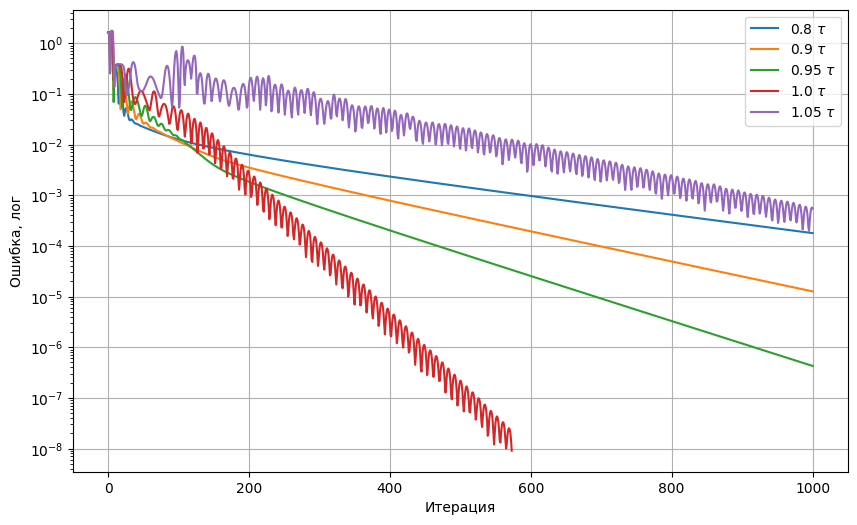

In [ ]:
max_iter = 1000
eps = 1e-8
gamma = 1.0 / L
tau_opt = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))

tau_coefficients = [0.8, 0.9, 0.95, 1.0, 1.05]#, 1.2]
taus = [coef * tau_opt for coef in tau_coefficients]

results = {}
for coef, tau in zip(tau_coefficients, taus):
    params = {'gamma': lambda k: gamma, 'tau': lambda k: tau}
    x_opt, values, errors = heavy_ball(A_train, b_train, lam, grad, criterion, x_0,
                                       eps, max_iter, **params)
    results[coef] = errors

plt.figure(figsize=(10, 6))
for coef, errors in results.items():
    plt.semilogy(errors, label=f'{coef} $τ$')
plt.xlabel('Итерация')
plt.ylabel('Ошибка, лог')
plt.legend()
plt.grid(True)
plt.show()

Отдельно для метода с 1.2 (расходится и остальные не видно)

100%|██████████| 1000/1000 [00:01<00:00, 567.35it/s]


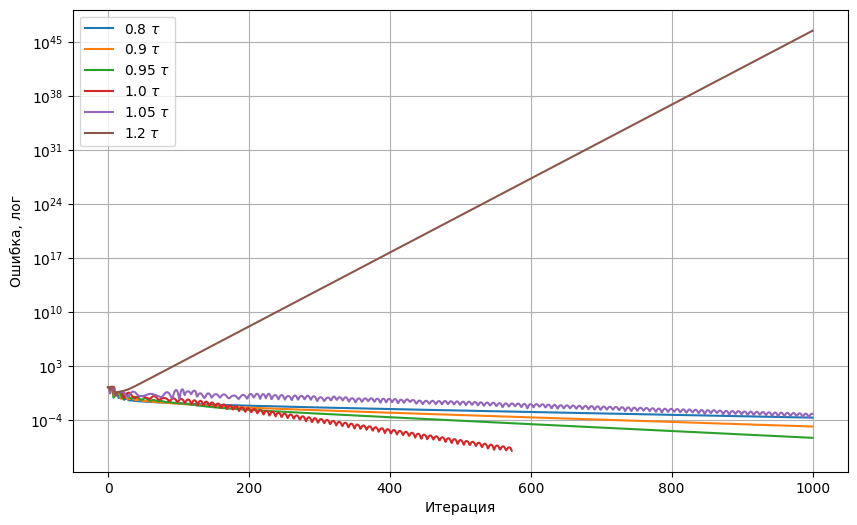

In [ ]:
max_iter = 1000
eps = 1e-8
gamma = 1.0 / L
tau_opt = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))

tau_coefficients = [0.8, 0.9, 0.95, 1.0, 1.05, 1.2]
taus = [coef * tau_opt for coef in tau_coefficients]

results = {}
for coef, tau in zip(tau_coefficients, taus):
    params = {'gamma': lambda k: gamma, 'tau': lambda k: tau}
    x_opt, values, errors = heavy_ball(A_train, b_train, lam, grad, criterion, x_0,
                                       eps, max_iter, **params)
    results[coef] = errors

plt.figure(figsize=(10, 6))
for coef, errors in results.items():
    plt.semilogy(errors, label=f'{coef} $τ$')
plt.xlabel('Итерация')
plt.ylabel('Ошибка, лог')
plt.legend()
plt.grid(True)
plt.show()

__б) (1 балл)__ Постройте сравнительный график, только теперь значение моментума будут зависеть от номера итерации. Сравните сходимости при
- $\tau = \frac{k}{k + 20}$;
- $\tau = \frac{k}{k + 10}$;
- $\tau = \frac{k}{k + 5}$;
- $\tau = \frac{k}{k + 1}$;
- Наилучший $\tau = const$.

 57%|█████▋    | 572/1000 [00:00<00:00, 657.15it/s]


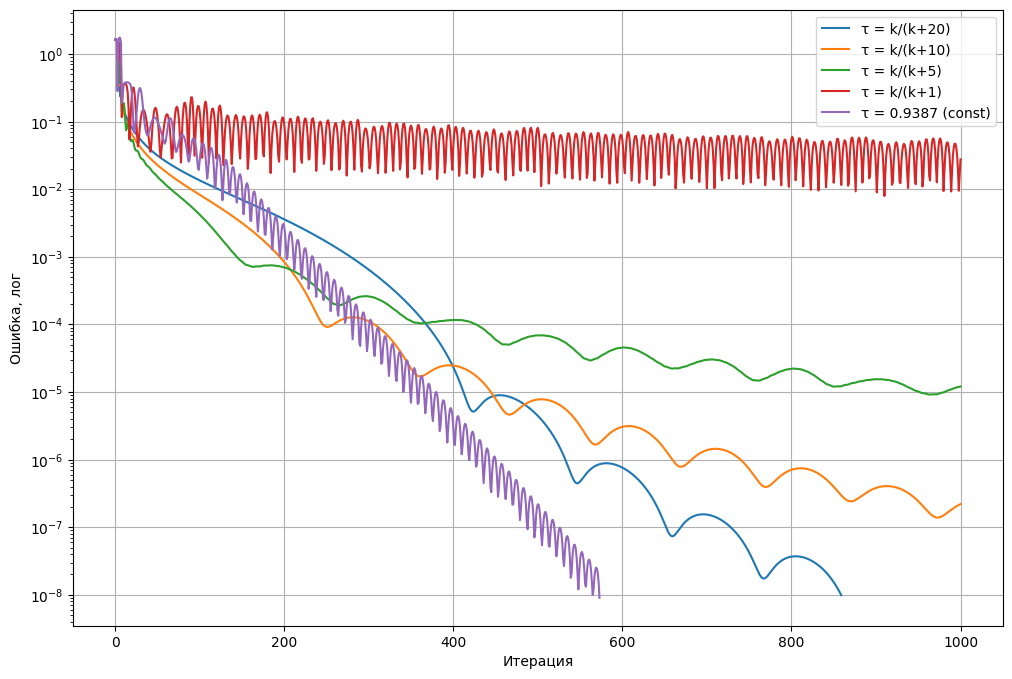

In [ ]:
taus = {
    'τ = k/(k+20)': lambda k: k/(k+20),
    'τ = k/(k+10)': lambda k: k/(k+10),
    'τ = k/(k+5)': lambda k: k/(k+5),
    'τ = k/(k+1)': lambda k: k/(k+1),
    f'τ = {tau_opt:.4f} (const)': lambda k: tau_opt
}

results = {}
for name, tau_func in taus.items():
    params = {'gamma': lambda k: gamma, 'tau': tau_func}
    x_opt, values, errors = heavy_ball(A_train, b_train, lam, grad,
                                       criterion, x_0, eps, max_iter, **params)
    results[name] = errors

plt.figure(figsize=(12, 8))
for name, errors in results.items():
    plt.semilogy(errors, label=name)
plt.xlabel('Итерация')
plt.ylabel('Ошибка, лог')
plt.legend()
plt.grid(True)
plt.show()

__в) (1 балл)__ Сравните метод тяжелого шарика с обычным градиентным спуском. Для этого реализуйте метод градиентного спуска, а сравнения проведите для лучшего значение моментума в методе тяжелого шарика со следующими значениями шагов (для каждого из методов):

- $\gamma_k = \frac{1}{2L}$,

- $\gamma_k = \frac{1}{L}$,

- $\gamma_k = \frac{2}{L}$,

- $\gamma_k = \frac{2}{\mu + L}$.



In [ ]:
def gradient_descent(A, b, lambda_value, grad, criterion, x_0, eps, max_iter, **params):
    """
    Реализация градиентного спуска.

    Параметры:
        A (np.array): Матрица признаков.
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        grad (Callable): Функция вычисления градиента
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций
        params : Именованные гиперпараметры метода
            params['gamma'] : шаг на k-ой итерации

    Возвращает:
        x_k (np.array) : Найденное решение
        values (list) : Список значений x_k на каждой итерации
        errors (list) : Список значений критерия сходимости на каждой итерации
    """
    values = []
    errors = []

    x_k = np.copy(x_0)
    values.append(x_k)
    errors.append(criterion(x_k, A, b, lambda_value))

    for k in tqdm(range(max_iter)):

        # YOUR CODE HERE
        g_k = grad(x_k, A, b, lambda_value)
        gamma_k = params['gamma'](k)
        x_k = x_k - gamma_k * g_k

        values.append(x_k)
        errors.append(criterion(x_k, A, b, lambda_value))
        if errors[-1] < eps:
            break

    return x_k, values, errors

In [ ]:
step_strategies = {
    'γ = 1/(2L)': 1/(2*L),
    'γ = 1/L': 1/L,
    'γ = 2/L': 2/L,
    'γ = 2/(μ+L)': 2/(mu+L)
}

results_gd = {}
results_hb = {}
for strategy_name, gamma_val in step_strategies.items():
    params_gd = {'gamma': lambda k: gamma_val}
    x_opt_gd, values_gd, errors_gd = gradient_descent(A_train, b_train,
                                                      lam, grad,
                                                      criterion, x_0, eps,
                                                      max_iter, **params_gd)
    results_gd[strategy_name] = errors_gd

100%|██████████| 1000/1000 [00:04<00:00, 230.61it/s]


 55%|█████▌    | 550/1000 [00:00<00:00, 719.90it/s]


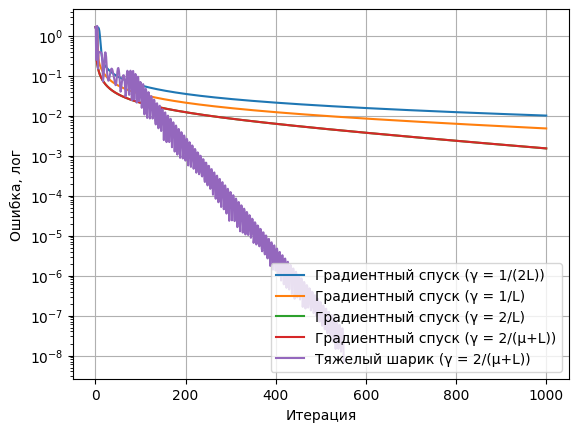

In [ ]:
tau_opt = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))

for name, gamma_val in step_strategies.items():
    params_hb = {'gamma': lambda k: gamma_val, 'tau': lambda k: tau_opt}
    x_opt_hb, values_hb, errors_hb = heavy_ball(A_train, b_train, lam,
                                                grad, criterion, x_0, eps,
                                                max_iter, **params_hb)
    results_hb[strategy_name] = errors_hb
for strategy_name, errors in results_gd.items():
    plt.semilogy(errors, label=f'Градиентный спуск ({strategy_name})')
for strategy_name, errors in results_hb.items():
    plt.semilogy(errors, label=f'Тяжелый шарик ({strategy_name})')

plt.xlabel('Итерация')
plt.ylabel('Ошибка, лог')
plt.legend()
plt.grid(True)
plt.show()

__г) (1.5 балла)__ Реализуйте ускоренный градиентный метод.

**Псевдокод алгоритма**

---

_Инициализация:_

- Размер шага $\{ \gamma_k \}_{k=0} > 0$
- Параметр момента $\{ \tau_k \}_{k=0} \in [0, 1]$
- Начальная точка $x^0 = x^{-1} \in \mathbb{R}^d$
- Максимальное число итераций $K$

---

$k$_-ая итерация_:

1. Обновить точку для следующего градиента:
   $$y^k = x^k + \tau_k \left(x^k - x^{k - 1} \right)$$

2. Сделать шаг градиентного спуска:
   $$x^{k+1} = y^k - \gamma_k \nabla f \left(y^k \right)$$

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$ или $\| \nabla f \left(x^k\right) \| < \varepsilon$

---

_Выход:_
- Полученное значение $x^K$

In [ ]:
def NAG(A, b, lambda_value, grad, criterion, x_0, eps, max_iter, **params):
    """
    Реализация метода ускоренного градиента Нестерова.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        grad (Callable): Функция вычисления градиента в точке
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка оптимизации
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций
        params : Именованные гиперпараметры метода
            params['gamma'](k) : функция шага на k-ой итерации
            params['tau'](k) : функция момента на k-ой итерации

    Возвращает:
        x_k (np.array) : Найденное решение
        values (list) : Список значений x_k на каждой итерации
        errors (list) : Список значений критерия сходимости на каждой итерации
    """
    values = []
    errors = []

    x_k = np.copy(x_0)
    x_k_old = np.copy(x_0)
    values.append(x_k)
    errors.append(criterion(x_k, A, b, lambda_value))

    gamma_get = params['gamma']
    tau_get   = params['tau']

    for k in tqdm(range(max_iter)):

        # YOUR CODE HERE
        tau_k = float(tau_get(k))
        y_k = x_k + tau_k * (x_k - x_k_old)

        gk = grad(y_k, A, b, lambda_value)
        gamma_k = float(gamma_get(k))

        x_next = y_k - gamma_k * gk
        x_k_old, x_k = x_k, x_next

        values.append(x_k)
        errors.append(criterion(x_k, A, b, lambda_value))
        if errors[-1] < eps:
            break

    return x_k, values, errors

Сравните его с методом тяжёлого шарика при тех же значениях моментума, что и в пункте __а)__.

**ВНИМАНИЕ: Там не очень видно с моментумом 1.2, закомментировал, можно убрать комментарий**

100%|██████████| 1000/1000 [00:01<00:00, 694.00it/s]


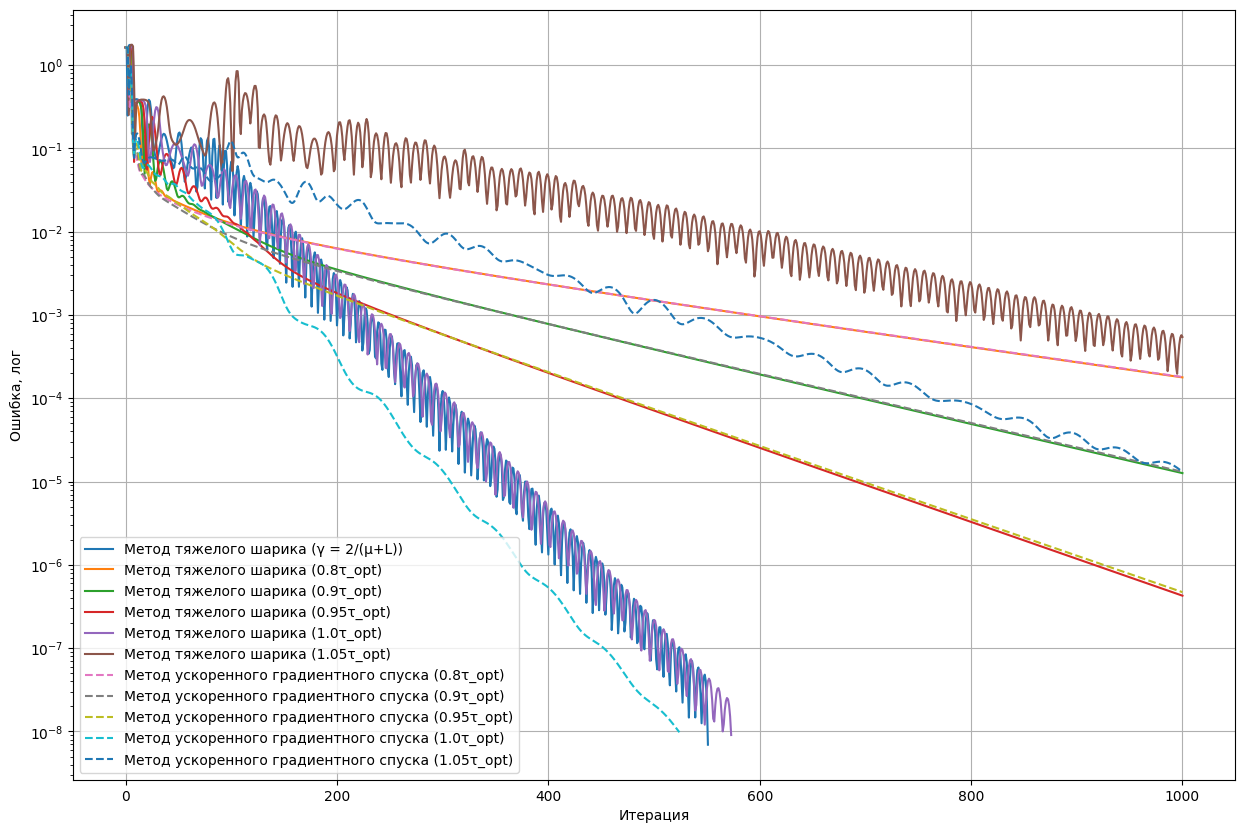

In [ ]:
# Ваше решение (Code)
lambda_value = L / 1000

tau_coefficients = [0.8, 0.9, 0.95, 1.0, 1.05]#, 1.2] # <- РАСКОММЕНТИРУЙТЕ ПРИ ЖЕЛАНИИ ПРИ ПРОВЕРКЕ
taus = [coef * tau_opt for coef in tau_coefficients]

results_nag = {}

for coef, tau in zip(tau_coefficients, taus):
    strategy_name = f'{coef}τ_opt'

    params_hb = {'gamma': lambda k: gamma, 'tau': lambda k: tau}
    x_opt_hb, values_hb, errors_hb = heavy_ball(A_train, b_train, lam, grad,
                                                criterion, x_0, eps, max_iter, **params_hb)
    results_hb[strategy_name] = errors_hb

    params_nag = {'gamma': lambda k: gamma, 'tau': lambda k: tau}
    x_opt_nag, values_nag, errors_nag = NAG(A_train, b_train, lam, grad,
                                            criterion, x_0, eps, max_iter, **params_nag
    )
    results_nag[strategy_name] = errors_nag

plt.figure(figsize=(15, 10))

for strategy_name, errors in results_hb.items():
    plt.semilogy(errors, label=f'Метод тяжелого шарика ({strategy_name})', linestyle='-')
for strategy_name, errors in results_nag.items():
    plt.semilogy(errors, label=f'Метод ускоренного градиентного спуска ({strategy_name})', linestyle='--')

plt.xlabel('Итерация')
plt.ylabel('Ошибка, лог')
plt.legend()
plt.grid(True)
plt.show()

__д) (0.5 балла)__ Наблюдать уменьшение критерия сходимости, конечно, замечательно, но хочется провалидироваться на тестовых данных. Для этого необходимо подсчитать отношение правильно предсказанных меток классов к их общему числу (метрика _accuracy_). Предложите способ, как оценить значение этой метрики. Помните, что функция $g(x, a_i)$ возвращает значение в диапазоне от 0 до 1.

###Решение
Нам нужно выставить пороговое значение, при котором вероятности классов будут считаться 1 или 0: <br>
$b_i = 1$ при $(b_i \geq threshold)$ <br>
Значение threshold при балансе обычно выбирают 0.5, но при дополнительных тестах можно подобрать более удачную для несбалансированных классов данных. <br>
После этого считает долю верных предсказаний: <br>
accuracy = $ \frac{1}{n} ​∑1 $ {b^i​\=bi} (при i=1 до n)

__е) (1 балл)__ Постройте графики значения метрики _accuracy_ для градиентного спуска, метода тяжёлого шарика и ускоренного градиентного спуска. Положите шаг равным $\frac{1}{L}$, а значение моментума подберите для каждого метода таким, на котором наблюдалась лучшая сходимость.

In [ ]:
def predict_proba(A, x):
    return sigmoid(A @ x)

def predict_labels(A, x, thr=0.5):
    return (predict_proba(A, x) >= thr).astype(int)

def accuracy(A, b, x, thr=0.5):
    return float((predict_labels(A, x, thr) == b).mean())

def accuracy_curve(A, b, xs, thr=0.5):
    return np.array([accuracy(A, b, x, thr=thr) for x in xs])

gamma_const = 1.0 / L
TAU_HB  = tau_opt
TAU_NAG = tau_opt

thr = 0.5

eps = 1e-8
max_iter = 100
x_0 = rng.random(A_train.shape[1])

gd_params  = {'gamma': lambda k: gamma_const}
hb_params  = {'gamma': lambda k: gamma_const, 'tau': lambda k: TAU_HB}
nag_params = {'gamma': lambda k: gamma_const, 'tau': lambda k: TAU_NAG}
x_gd,  vals_gd,  _ = gradient_descent(A_train, b_train, lam, grad, criterion, x_0, eps, max_iter, **gd_params)
x_hb,  vals_hb,  _ = heavy_ball(A_train, b_train, lam, grad, criterion, x_0, eps, max_iter, **hb_params)
x_nag, vals_nag, _ = NAG(A_train, b_train, lam, grad, criterion, x_0, eps, max_iter, **nag_params)
acc_gd_test  = accuracy_curve(A_test, b_test, vals_gd,  thr=thr)
acc_hb_test  = accuracy_curve(A_test, b_test, vals_hb,  thr=thr)
acc_nag_test = accuracy_curve(A_test, b_test, vals_nag, thr=thr)

100%|██████████| 100/100 [00:00<00:00, 608.95it/s]


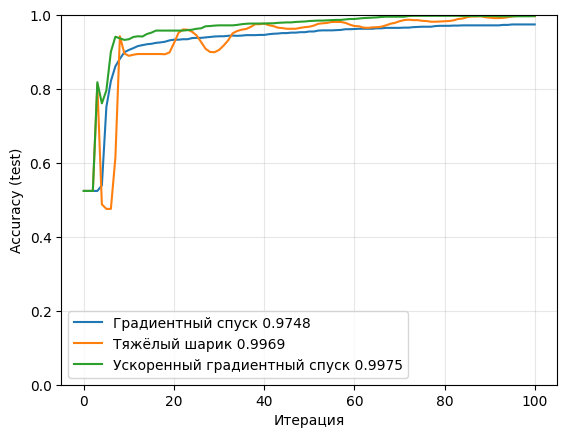

In [ ]:
plt.figure()
plt.plot(acc_gd_test,  label=f"Градиентный спуск {acc_gd_test[-1]:.4f}")
plt.plot(acc_hb_test,  label=f"Тяжёлый шарик {acc_hb_test[-1]:.4f}")
plt.plot(acc_nag_test, label=f"Ускоренный градиентный спуск {acc_nag_test[-1]:.4f}")
plt.ylim(0.0, 1.0)
plt.xlabel("Итерация")
plt.ylabel("Accuracy (test)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Дополнительная часть (10 баллов)

__Задача 3.__ До этого, в рамках метода градиентного спуска, мы использовали константный и зависящий от номера итерации шаг. В случае неоптимального подбора, алгоритм может требовать сильно большее число итераций для достижения сходимости. Отсюда возникает идея использовать шаги, которые бы зависели от некоторых параметров функции.

Сделаем так: будем искать такой шаг $\gamma_k$ в точке $x^k$, чтобы значение функции в следующей точке было достаточно малым (относительно текущей точки). В идеале, мы хотим решить следующее:

$$
\gamma_k = \arg \min_{\gamma_k} f \left(x^k + \gamma_k p^k \right),~ \text{где $p^k$ — это направление куда мы хотим двигаться.}
$$

Этот алгоритм в общем виде называется _линейный поиск_. Для градиентного спуска $p^k$ — это просто антиградиент.

Как нетрудно заметить, основная проблема заключается в том, что отрешивать $\arg \min$ на каждой итерации спуска — вычислительно сложная задача, которая хоть и даст улучшение по числу итераций, но сильно повысит временные затраты алгоритма. В данной задаче мы изучим различные методы поиска $\gamma_k$, которые начинают с некоторого стартового шага $\gamma_0$ и уменьшают его до тех пор, пока не выполнится необходимое условие приемлемости шага.

__а) (2 балла)__ Первым рассмотрим условие Армихо. Эта стратегия основывается на следующей идее: мы хотим из точки $x^k$ попасть в такую точку $x^{k+1}$, что значение функции в ней достаточно мало по сравнению со значением функции в текущей точке. Но под "достаточно мало" мы понимаем не просто уменьшение, а уменьшение с определённой скоростью, соответствующей направлению спуска. Чтобы это количественно формализовать, будем сравнивать значение функции в новой точке с значением касательной прямой, проведённой в точке $x^k$ в направлении $h^k$. Если новая точка оказывается ниже этой прямой — шаг подходит. Для надёжности наклон касательной немного уменьшают, домножая на коэффициент $c_1 \in (0, 1)$, чтобы не требовать слишком сильного убывания и избежать отбрасывания хороших шагов.

Из вышесказанного получается следующее условие:

$$
f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f(x^k), h^k \rangle.
$$

Это неравенство можно получить, записав линейное приближение функции $f\left(x^k + \gamma_k h^k \right)$ до первого порядка разложения в точке $x^k$, и затем требуя, чтобы значение функции не просто уменьшилось, а оказалось ниже этого приближения с некоторым запасом.

В случае градиентного спуска $h^k = -\nabla f\left(x^k\right)$ неравенство принимает вид:

$$
f\left(x^k - \gamma_k \nabla f\left( x^k \right)\right) \leq f\left(x^k\right) - \beta_1 \gamma_k \left\| \nabla f\left(x^k\right) \right\|_2^2.
$$

Для удобства, допишите общий метод `gradient_descent_optimal_steps`, который будет принимать в себя различные правила поисков шага (`line_search`), а также напишите функцию `armijo`, вычисляющее приближенное значение $\gamma_k$ за определенное количество итераций.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\gamma_0 > 0$
- Направление спуска $h^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметр $\beta_1 \in (0, 1)$

---

1. Проверить условие Армихо:

$$
f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f(x^k), h^k \rangle
$$

2. Если условие выполнено — вернуть $\gamma_k$. Иначе — уменьшить шаг:

    $$
    \gamma_k = m \cdot \gamma_k
    $$

    и вернуться к 1.

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\gamma_k$

In [ ]:
def gradient_descent_optimal_steps(A, b, lambda_value, loss, grad, line_search, criterion, x_0, eps=1e-8,
                                   max_iter=1000, **params):
    """
    Реализация градиентного спуска с оптимальным подбором шага.

    Параметры:
        A (np.array): Матрица признаков размерности
        b (np.array): Вектор целевых значений размерности
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        line_search (Callable): Функция подбора шага
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка оптимизации
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций
        params (dict): Дополнительные параметры для line_search:
            params['beta1'] (float): Первый параметр (обычное 1e-4)
            params['beta2'] (float): Второй параметр (не используется в правиле Армихо)
            params['gamma_mult'] (float): Множитель для уменьшения шага (обычно 0.5)
            params['line_search_max_iter'] (int): Макс. итераций подбора шага (обычно 100)
            params['gamma0'] (float): Начальное значение шага (обычно 1e-2)

    Возвращает:
        x_k (np.array): Найденное решение
        values (list): История значений x на каждой итерации
        errors (list): История значений критерия сходимости
    """
    values = []
    errors = []

    x_k = np.copy(x_0)
    values.append(x_k)
    errors.append(criterion(x_k, A, b, lambda_value))

    for k in tqdm(range(max_iter)):

        # YOUR CODE HERE

        gk = grad(x_k, A, b, lambda_value)
        h  = -gk

        gamma_k = line_search(A, b, lambda_value, loss, grad, x_k, h,
            params.get('beta1', 1e-4), params.get('beta2', 0),
            params.get('gamma_mult', 0.5), params.get('line_search_max_iter', 100),
            params.get('gamma0', 1e-2)
        )
        x_k = x_k + gamma_k * h

        values.append(x_k)
        errors.append(criterion(x_k, A, b, lambda_value))
        if errors[-1] < eps:
            break

    return x_k, values, errors

In [ ]:
def armijo(A, b, lambda_value, loss, grad, x, h, beta1, beta2, gamma_mult, max_iters, gamma0):
    """
    Правило Армихо.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь f(x)
        grad (Callable): Функция вычисления градиента ∇f(x)
        x (np.array): Текущая точка
        h (np.array): Направление спуска (обычно -∇f(x))
        beta1 (float): Параметр условия достаточного убывания (обычно 1e-4)
        beta2 (float): Не используется, оставлен для совместимости, по умолчанию 0
        gamma_mult (float): Множитель уменьшения шага (обычно 0.5)
        max_iters (int): Максимальное число итераций подбора (обычно 100)
        gamma0 (float): Начальное значение шага

    Возвращает:
        gamma (float): Найденное значение шага, удовлетворяющее условию Армихо
    """
    gamma= gamma0
    counter= 0
    current_loss= loss(x, A, b, lambda_value)
    grad_x= grad(x, A, b, lambda_value)
    directional_derivative= grad_x.dot(h)

    while counter < max_iters:

        x_new = x + gamma * h
        new_loss = loss(x_new, A, b, lambda_value)

        if new_loss <= current_loss+beta1*gamma*directional_derivative:
            break

        gamma *= gamma_mult
        counter += 1

    return gamma

Запустите градиентный спуск с правилом Армихо, рассмотрев разные значения для начальной инициализации $\gamma_0$ и базовыми значениями для других параметров:
- $\gamma_0 = 10^{-2}$ — стандартное значение;
- $\gamma_0 = 10^{-1}$;
- $\gamma_0 = 1$;
- $\gamma_0 = 5$.
- $\gamma_0 = 10$.
- $\gamma_0 = 15$.

В качестве множителя уменьшения шага рассмотрите $m = 0.5$. В качестве параметра $\beta_1$ возьмите $\beta_1 = 10^{-4}$.

 65%|██████▍   | 646/1000 [00:04<00:02, 155.18it/s]


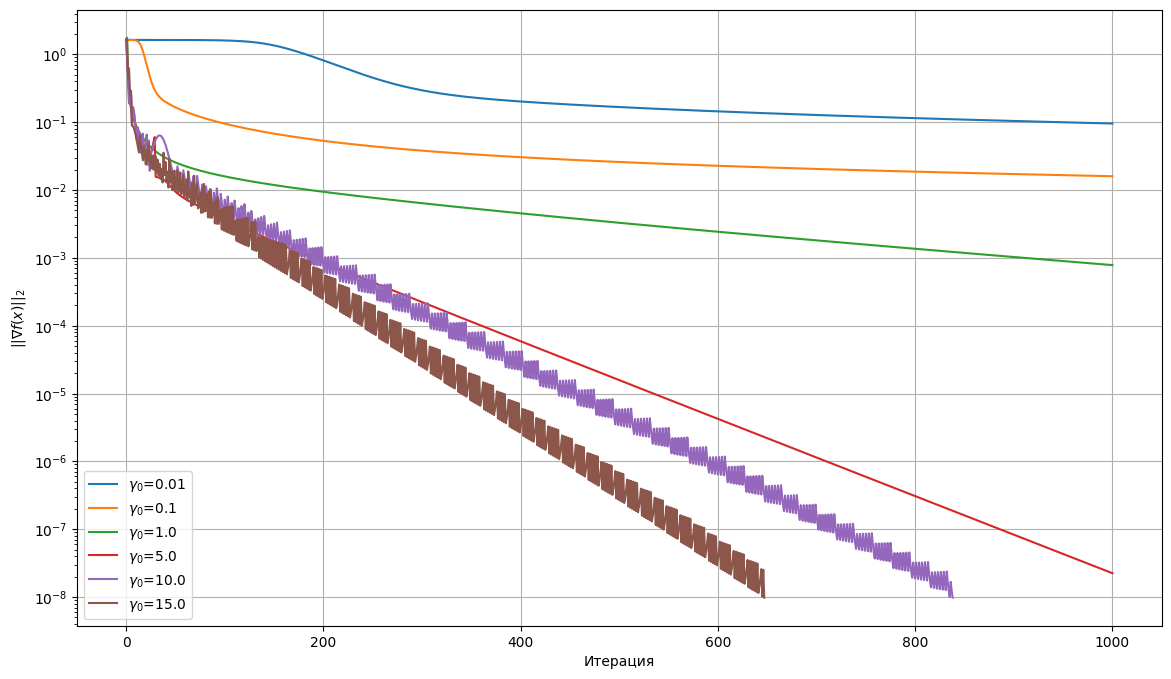

In [ ]:
gamma0_list = [1e-2, 1e-1, 1.0, 5.0, 10.0, 15.0]
m = 0.5
beta1 = 1e-4
eps = 1e-8
max_iter = 1000

results = {}

plt.figure(figsize=(14, 8))
for gamma_0 in gamma0_list:
    params = dict(beta1=beta1, beta2=0.0, gamma_mult=m, line_search_max_iter=100, gamma0=gamma_0)

    x_end, values, errors = gradient_descent_optimal_steps(A_train, b_train,
        lam, loss, grad, armijo, criterion, x_0, eps=eps, max_iter=max_iter, **params
    )

    errs = np.asarray(errors)
    results[gamma_0] = (x_end, values, errs)

    plt.plot(errs, label=f"$\gamma_0$={gamma_0}")

fin.append(errs)

plt.yscale('log')
plt.xlabel('Итерация')
plt.ylabel('$||∇f(x)||_2$')
plt.grid()
plt.legend()
plt.show()

Почему наблюдается худшая сходимость при меньших значений $\gamma_0$?

**При меньших значениях $\gamma_0$ условие Армихо выполняется сразу же и оно уже слишком маленькое, но всё равно алгоритмом берётся оно -> медленная сходимость**

__б) (2 балла)__ Хоть правило Армихо и отсекает некоторое количество неудачных шагов, всё же оно не определяет шаг строго — остаётся достаточно широкий выбор допустимых значений $\gamma$, удовлетворяющих неравенству. Это может привести к выбору слишком малого шага, особенно если взять $\gamma$ достаточно маленьким с самого начала — тогда условие Армихо будет выполнено, но скорость сходимости существенно снизится. Вы могли убедиться в этом в предыдущем пункте, где даже слишком маленький шаг удовлетворял критерию.

Чтобы избежать этой проблемы, используется _правило Гольдштейна_, которое сужает диапазон допустимых значений $\gamma$, добавляя нижнюю границу на приращение функции. Оно использует ту же линейную аппроксимацию, но требует, чтобы значение функции не было слишком маленьким — то есть, чтобы шаг не оказался чересчур осторожным. Условие Гольдштейна выглядит следующим образом:

$$
f\left(x^k\right) + \beta_2 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle \leq f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle,
$$

где $0 < \beta_1 < \beta_2 < 1$. Таким образом, выбираются такие $\gamma$, которые дают достаточное, но не чрезмерное убывание функции. Это может значительно ускорить сходимость, особенно на начальных этапах, когда длина шага критична для быстрого продвижения к минимуму.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\gamma_0 > 0$
- Направление спуска $h^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметры $\beta_1, \beta_2 \in (0, 1)$

---

1. Проверить условие Гольдштейна:

$$
f\left(x^k\right) + \beta_2 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle \leq f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle
$$

2. Если условие выполнено — вернуть $\gamma_k$. Иначе — уменьшить шаг:

    $$
    \gamma_k = m \cdot \gamma_k
    $$

    и вернуться к 1

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\gamma_k$

In [ ]:
def goldstein(A, b, lambda_value, loss, grad, x, h, beta1, beta2, gamma_mult, max_iters, gamma0):
    """
    Правило Гольдштейна.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь f(x)
        grad (Callable): Функция вычисления градиента ∇f(x)
        x (np.array): Текущая точка
        h (np.array): Направление спуска (обычно -∇f(x))
        beta1 (float): Параметр условия достаточного убывания (обычно 1e-4)
        beta2 (float): Не используется, оставлен для совместимости, по умолчанию 0
        gamma_mult (float): Множитель уменьшения шага (обычно 0.5)
        max_iters (int): Максимальное число итераций подбора (обычно 100)
        gamma0 (float): Начальное значение шага

    Возвращает:
        gamma (float): Найденное значение шага, удовлетворяющее условию Гольдштейна
    """
    gamma = gamma0
    counter = 0
    current_loss = loss(x, A, b, lambda_value)
    grad_x = grad(x, A, b, lambda_value)
    directional_derivative = grad_x.dot(h)

    while counter < max_iters:


        # YOUR CODE HERE
        x_new = x + gamma * h
        new_loss = loss(x_new, A, b, lambda_value)

        l = current_loss + beta2*gamma*directional_derivative
        r = current_loss + beta1*gamma*directional_derivative

        if (new_loss >= l) and (new_loss <= r):
            break;

        gamma *= gamma_mult
        counter += 1

    return gamma

Запустите правило Гольдштейна с параметрами $\gamma_0$ из __а)__. В качестве множителя уменьшения шага рассмотрите $m = 0.5$. В качестве параметров $\beta_1$ и $\beta_2$ возьмите $\beta_1 = 10^{-4}$ и $\beta_2 = 1 - 10^{-4}$.

 65%|██████▍   | 646/1000 [00:04<00:02, 153.85it/s]


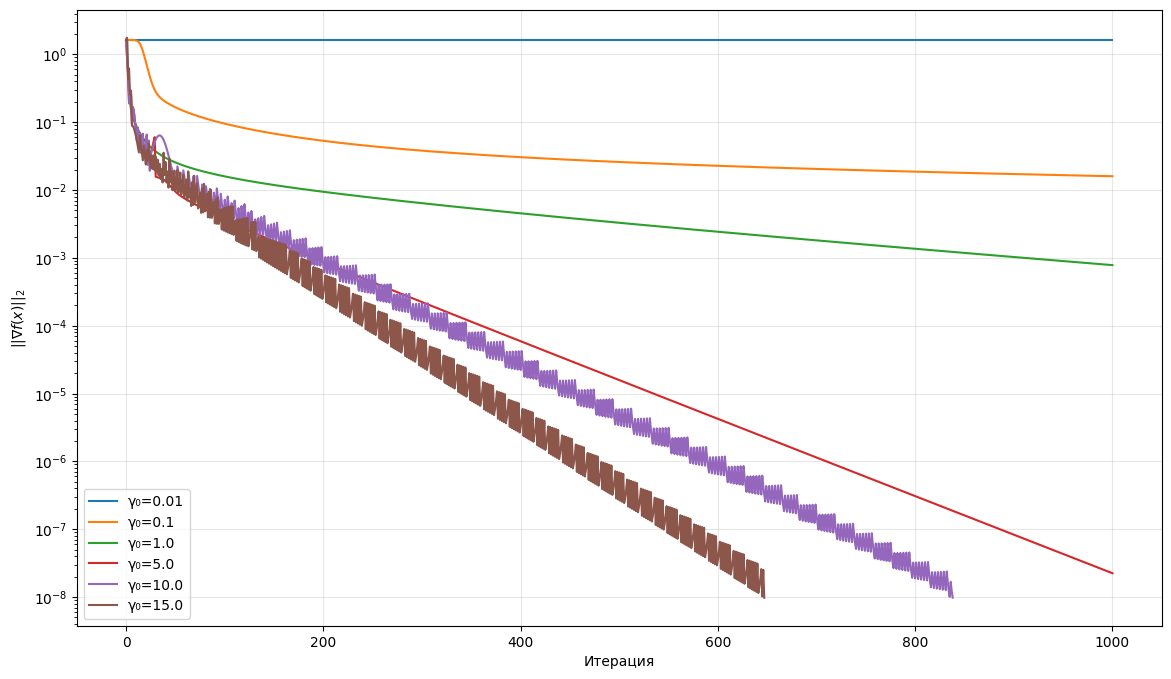

In [ ]:
# Ваше решение (Code)
beta1 = 1e-4
beta2 = 1 - 1e-4
max_iter = 1000

plt.figure(figsize=(14, 8))
for gamma_0 in gamma0_list:
    params = dict(
        beta1=beta1,
        beta2=beta2,
        gamma_mult=m,
        line_search_max_iter=100,
        gamma0=gamma_0)

    x_end, values, errors = gradient_descent_optimal_steps(
        A_train, b_train, lam, loss, grad, goldstein, criterion,
        x_0, eps=eps, max_iter=max_iter, **params)


    errs = np.asarray(errors)
    plt.plot(errs, label=f"γ₀={gamma_0}")

fin.append(errs)

plt.yscale('log')
plt.xlabel('Итерация')
plt.ylabel('$||∇f(x)||_2$')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Есть ли улучшение сходимости? Объясните, почему.

In [ ]:
# Ваше решение (Markdown)
'''
Улучшения сходимости нет. Гольдштейн -> двустороннее ограничение.
Возможно, так как beta1 слишком маленькая, а beta2 слишком большая, поэтому
получается то же самое, как у Армихо.
'''

'\nУлучшения сходимости нет. Гольдштейн -> двустороннее ограничение.\nВозможно, так как beta1 слишком маленькая, а beta2 слишком большая, поэтому\nполучается то же самое, как у Армихо.\n'

__в) (2 балла)__ Условие Гольдштейна реализует наивное отсечение. Теперь рассмотрим точки, в которых наша функция не убывает так сильно, как в текущей. Конкретнее, нас интересуют такие значения шага, при которых производная по направлению $h^k$ не уменьшилась сильно по сравнению с тем, что было в начале, то есть:

$$
\langle \nabla f \left(x^k + \gamma_k h^k\right),  h^k \rangle \geq \beta_2 \langle \nabla f \left(x^k\right), h^k \rangle.
$$

Это условие называется условием кривизны (curvature condition). Его смысл — убедиться, что градиент в новой точке не стал слишком плоским по направлению $h^k$, то есть мы не зашли слишком далеко в область, где функция уже почти не меняется. Такое поведение может привести к медленной сходимости и ухудшению качества шага.

Правило Вольфа объединяет два требования: условие Армихо, которое гарантирует достаточное убывание функции, и условие кривизны, которое ограничивает чрезмерное затухание производной. Таким образом, шаг выбирается только в том случае, если оба этих условия выполняются одновременно.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\gamma_0 > 0$
- Направление спуска $h^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметры $\beta_1, \beta_2 \in (0, 1)$

---

1. Проверит условие Армихо:

$$
f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle
$$

2. Проверить условие кривизны

$$
\langle \nabla f \left(x^k + \gamma_k h^k\right),  h^k \rangle \geq \beta_2 \langle \nabla f \left(x^k\right), h^k \rangle
$$

2. Если оба условия выполняются, вернуть $\gamma_k$. Если не выполняется Армихо — уменьшить шаг:

    $$\gamma_k = \gamma_k \cdot m$$

    и вернуться к 1. Иначе — увеличить шаг:

    $$\gamma_k = \gamma_k / m$$

    и вернуться к 1

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\gamma_k$

In [ ]:
def wolfe(A, b, lambda_value, loss, grad, x, h, beta1, beta2, gamma_mult, max_iters, gamma0):
    """
    Правило Вольфа.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь f(x)
        grad (Callable): Функция вычисления градиента ∇f(x)
        x (np.array): Текущая точка
        h (np.array): Направление спуска (обычно -∇f(x))
        beta1 (float): Параметр условия достаточного убывания (обычно 1e-4)
        beta2 (float): Не используется, оставлен для совместимости, по умолчанию 0
        gamma_mult (float): Множитель уменьшения шага (обычно 0.5)
        max_iters (int): Максимальное число итераций подбора (обычно 100)
        gamma0 (float): Начальное значение шага

    Возвращает:
        gamma (float): Найденное значение шага, удовлетворяющее условию Гольдштейна
    """
    gamma = gamma0
    counter = 0
    current_loss = loss(x, A, b, lambda_value)
    grad_x = grad(x, A, b, lambda_value)
    directional_derivative = grad_x.dot(h)

    while counter < max_iters:

        # YOUR CODE HERE



        x_new = x + gamma * h
        new_loss = loss(x_new, A, b, lambda_value)

        if new_loss > current_loss + beta1*gamma*directional_derivative:
            gamma *= gamma_mult
            counter += 1
            continue

        grad_new = grad(x_new, A, b, lambda_value)
        dir_der_new = grad_new.dot(h)

        if dir_der_new < beta2 * directional_derivative:
            gamma /= gamma_mult
            counter += 1
            continue

        break


    return gamma

Запустите правило Вольфа с параметрами $\gamma_0$ из __а)__. В качестве множителя уменьшения шага рассмотрите $m = 0.5$. В качестве параметров $\beta_1$ и $\beta_2$ возьмите $\beta_1 = 10^{-4}$ и $\beta_2 = 0.9$.

 65%|██████▍   | 646/1000 [00:04<00:02, 133.60it/s]


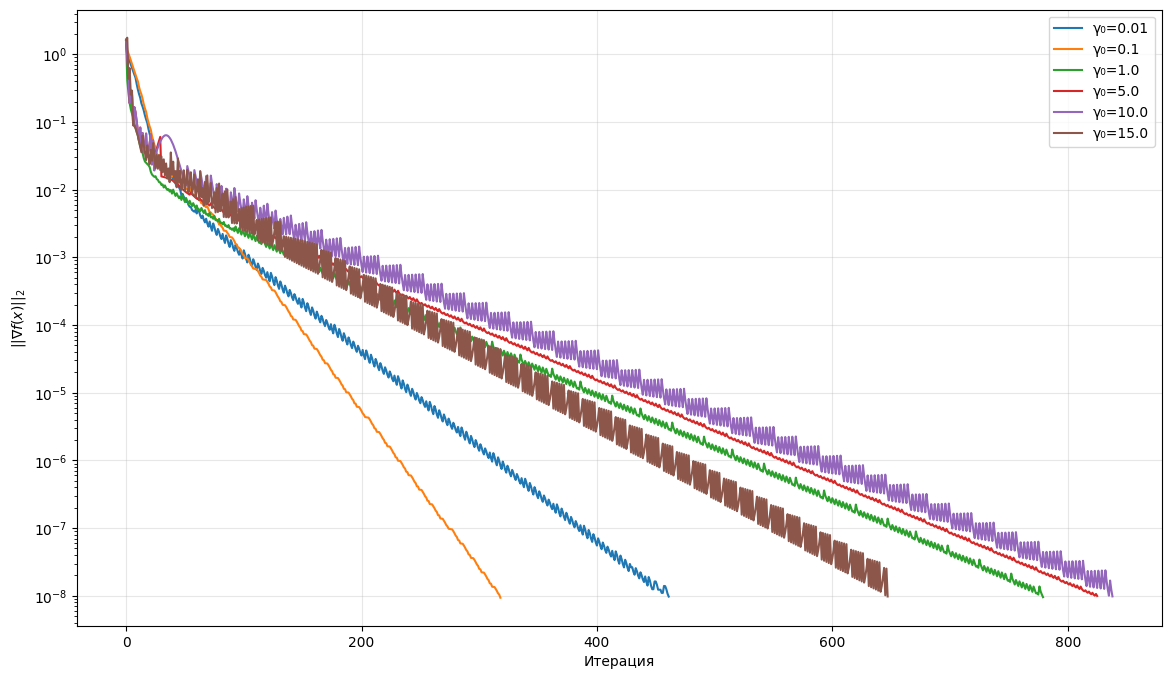

In [ ]:
# Ваше решение (Code)
beta1 = 1e-4
beta2 = 0.9
max_iter = 1000

plt.figure(figsize=(14, 8))
for gamma_0 in gamma0_list:
    params = dict(beta1=beta1, beta2=beta2, gamma_mult=m,
        line_search_max_iter=100, gamma0=gamma_0)

    x_end, values, errors = gradient_descent_optimal_steps(
        A_train, b_train, lam, loss, grad, wolfe, criterion,
        x_0, eps=eps, max_iter=max_iter, **params)

    errs = np.asarray(errors)
    plt.plot(errs, label=f"γ₀={gamma_0}")

fin.append(errs)

plt.yscale('log')
plt.xlabel('Итерация')
plt.ylabel('$||∇f(x)||_2$')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


__г) (2 балла)__ Обычное условие кривизны может допускать ситуацию, когда производная по направлению в новой точке становится положительной, что приводит к тому, что неравенство всегда выполняется. Чтобы исключить этот случай, можно использовать модули для проверки абсолютного значения градиента:

$$
|\langle \nabla f \left(x^k + \gamma_k h^k\right),  h^k \rangle| \leq \beta_2 |\langle \nabla f \left(x^k\right), h^k \rangle|.
$$

Знак меняется, потому что справа мы имеем отрицательное значение, которое становится положительным. Мы хотим, чтобы абсолютное значение производной в новой точке было близким к нулю, так как в оптимуме градиент должен быть равен нулю, а это гарантирует, что шаг был выбран правильно и направлен в сторону минимума.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\gamma_0 > 0$
- Направление спуска $h^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметры $\beta_1, \beta_2 \in (0, 1)$

---

1. Проверит условие Армихо:

$$
f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle
$$

2. Проверить сильное условие кривизны

$$
|\langle \nabla f \left(x^k + \gamma_k h^k\right),  h^k \rangle| \leq \beta_2 |\langle \nabla f \left(x^k\right), h^k \rangle|
$$

2. Если оба условия выполняются, вернуть $\gamma_k$. Если не выполняется Армихо или направление положительное — уменьшить шаг:

    $$\gamma_k = \gamma_k \cdot m$$

    и вернуться к 1. Иначе — увеличить шаг:

    $$\gamma_k = \gamma_k / m$$

    и вернуться к 1

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\gamma_k$

In [ ]:
def strong_wolfe(A, b, lambda_value, loss, grad, x, h, beta1, beta2, gamma_mult, max_iters, gamma0):
    """
    Сильное правило Вольфа.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь f(x)
        grad (Callable): Функция вычисления градиента ∇f(x)
        x (np.array): Текущая точка
        h (np.array): Направление спуска (обычно -∇f(x))
        beta1 (float): Параметр условия достаточного убывания (обычно 1e-4)
        beta2 (float): Не используется, оставлен для совместимости, по умолчанию 0
        gamma_mult (float): Множитель уменьшения шага (обычно 0.5)
        max_iters (int): Максимальное число итераций подбора (обычно 100)
        gamma0 (float): Начальное значение шага

    Возвращает:
        gamma (float): Найденное значение шага, удовлетворяющее условию Гольдштейна
    """
    gamma = gamma0
    counter = 0
    current_loss = loss(x, A, b, lambda_value)
    grad_x = grad(x, A, b, lambda_value)
    directional_derivative = grad_x.dot(h)

    while counter < max_iters:

        x_new = x + gamma * h
        new_loss = loss(x_new, A, b, lambda_value)

        if new_loss > current_loss +beta1*gamma*directional_derivative:
            gamma *= gamma_mult
            counter += 1
            continue

        grad_new = grad(x_new, A, b, lambda_value)
        dir_der_new = float(grad_new.dot(h))
        if abs(dir_der_new) > beta2*abs(directional_derivative):
            gamma /= gamma_mult
            counter += 1
            continue

        break

    return gamma

Запустите правило усиленного Вольфа с параметрами $\gamma_0$ из __а)__. В качестве множителя уменьшения шага рассмотрите $m = 0.5$. В качестве параметров $\beta_1$ и $\beta_2$ возьмите $\beta_1 = 10^{-4}$ и $\beta_2 = 0.9$.

 61%|██████    | 607/1000 [00:16<00:10, 37.79it/s]


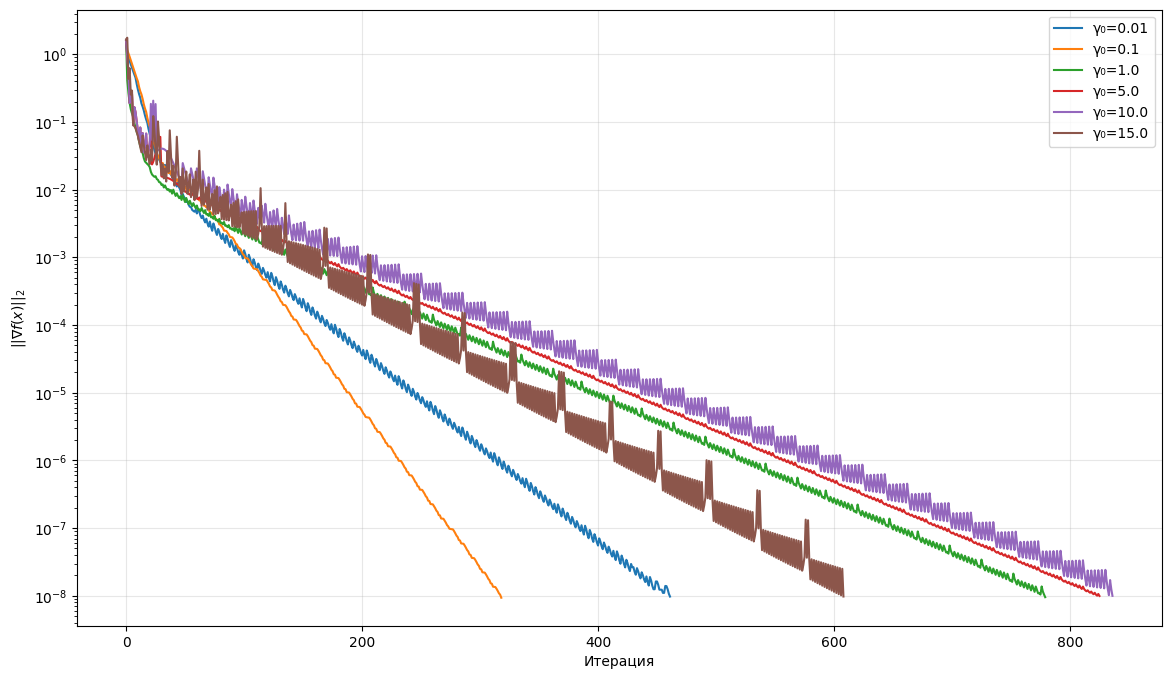

In [ ]:
# Ваше решение (Code)
beta1 = 1e-4
beta2 = 0.9
max_iter = 1000

plt.figure(figsize=(14, 8))
for gamma_0 in gamma0_list:
    params = dict(beta1=beta1, beta2=beta2, gamma_mult=m,
        line_search_max_iter=100, gamma0=gamma_0)

    x_end, values, errors = gradient_descent_optimal_steps(
        A_train, b_train, lam, loss, grad, strong_wolfe, criterion,
        x_0, eps=eps, max_iter=max_iter, **params)

    errs = np.asarray(errors)
    plt.plot(errs, label=f"γ₀={gamma_0}")

fin.append(errs)

plt.yscale('log')
plt.xlabel('Итерация')
plt.ylabel('$||∇f(x)||_2$')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


__д) (2 балла)__ Сделайте итоговое сравнение методов. Постройте график и укажите, какой оказался наиболее эффективным, для следующих методов: градиентный спуск с лучшим шагом, ускоренный градиентный метод с оптимальными параметрами или градиентный спуск с адаптивным шагом (Армихо, Гольдштейн, Вольф или усиленный Вольф).

In [ ]:
gamma0 = 0.1
m = 0.5
beta1 = 1e-4
beta2 = 0.9
eps = 1e-8
max_iter = 1000

In [ ]:
step_strategies = { 'γ = 2/(μ+L)': 2/(mu+L)}
max_iter = 1000
eps = 1e-8
gamma = 1.0 / L
tau_opt = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))

results_gd = {}
for strategy_name, gamma_val in step_strategies.items():
    params_gd = {'gamma': lambda k: gamma_val}
    x_opt_gd, values_gd, res1 = gradient_descent(A_train, b_train,
                                                      lam, grad,
                                                      criterion, x_0, eps,
                                                      max_iter, **params_gd)
    #res1

100%|██████████| 1000/1000 [00:03<00:00, 281.30it/s]


In [ ]:
lambda_value = L / 1000
tau_coefficients = [1.0]
taus = [coef * tau_opt for coef in tau_coefficients]

results_nag = {}

for coef, tau in zip(tau_coefficients, taus):
    strategy_name = f'{coef}τ_opt'

    params_nag = {'gamma': lambda k: gamma, 'tau': lambda k: tau}
    x_opt_nag, values_nag, res2 = NAG(A_train, b_train, lam, grad,
                                            criterion, x_0, eps, max_iter, **params_nag
    )
    #res2


 52%|█████▏    | 520/1000 [00:00<00:00, 709.80it/s]


 65%|██████▍   | 646/1000 [00:04<00:02, 150.72it/s]


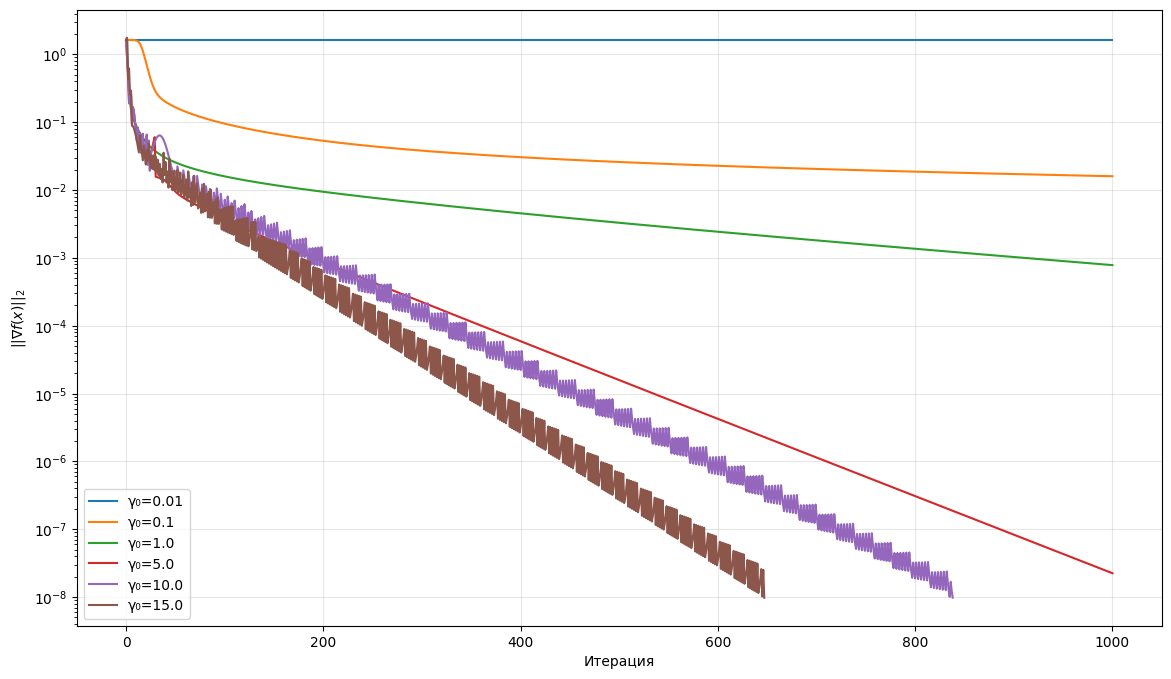

In [ ]:
beta1 = 1e-4
beta2 = 1 - 1e-4
max_iter = 1000

plt.figure(figsize=(14, 8))
for gamma_0 in gamma0_list:
    params = dict(
        beta1=beta1,
        beta2=beta2,
        gamma_mult=m,
        line_search_max_iter=100,
        gamma0=gamma_0)

    x_end, values, errors = gradient_descent_optimal_steps(
        A_train, b_train, lam, loss, grad, goldstein, criterion,
        x_0, eps=eps, max_iter=max_iter, **params)


    errs = np.asarray(errors)
    plt.plot(errs, label=f"γ₀={gamma_0}")


plt.yscale('log')
plt.xlabel('Итерация')
plt.ylabel('$||∇f(x)||_2$')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

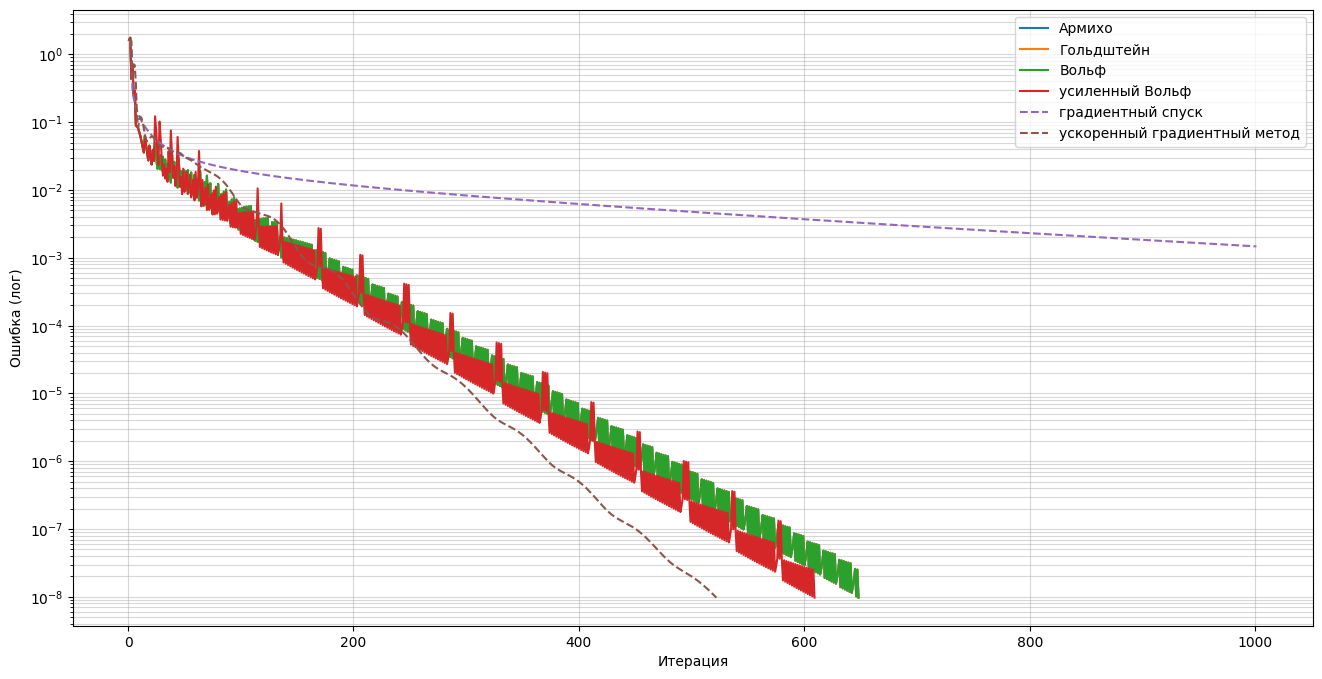

In [ ]:
method_names = ['Армихо', 'Гольдштейн', 'Вольф', 'усиленный Вольф']

plt.figure(figsize=(16,8))

for series, name in zip(fin, method_names):
    y = np.asarray(series, dtype=float)
    if y.size == 0:
        continue
    x = np.arange(1, len(y)+1)
    plt.plot(x, y, label=name)

for series, name in [(res1, "градиентный спуск"), (res2, "ускоренный градиентный метод")]:
    if series is None:
        continue
    y = np.asarray(series, dtype=float)
    x = np.arange(1, len(y)+1)
    plt.plot(x, y, label=name, linestyle="--")

plt.yscale("log")
plt.xlabel("Итерация")
plt.ylabel("Ошибка (лог)")
plt.grid(True, which="both", alpha=0.5)
plt.legend()
plt.show()

### Ответ:
Ускоренный градиентный спуск